## Assigmnent 3

In [1]:
#https://www.kaggle.com/datasets/avk256/activity-recognition

SyntaxError: invalid syntax (3236137079.py, line 1)

In [2]:

"""
import os

for filename in os.listdir('sensorlogger'):
    f = os.path.join('sensorlogger', filename)
    
    if os.path.isfile(f):
   """     



"\nimport os\n\nfor filename in os.listdir('sensorlogger'):\n    f = os.path.join('sensorlogger', filename)\n    \n    if os.path.isfile(f):\n   "

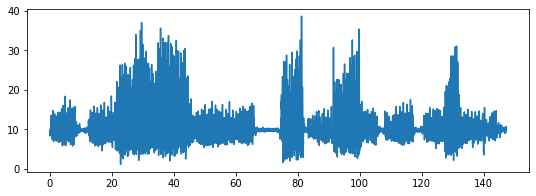

In [15]:
import numpy as np
import matplotlib.pyplot as plt

with open('sensorlogger/sensorLog_20240715T191803.txt') as file:        
    lines = [line.split() for line in file]

acc = [ np.sqrt(float(line[2])**2 + float(line[3])**2 + float(line[4])**2) for line in lines ]
t = [(float(line[0])-float(lines[0][0]))/1000 for line in lines]

plt.figure(figsize= (9,3))
plt.plot(t, acc)
plt.show()


In [18]:
"""Windowing"""

rec_length = len(acc)/100
print(rec_length)

176.51


In [ ]:


"""Initialization"""

"""Infinite ergodic HMM may start in any state. Assumption here is that
    each state is equally likely to occur as initial state"""

mc = MarkovChain( np.full((1,3)1/3) , np.array( [ [ 0.9, 0, 0 ], [ 0, 0.9, 0.1 ], [0, 0 ,0] ] ) )

"""The diagonal elements of the transition matrix can be chosen to indicate 
    approximately the average state durations. Average recording duration ~34s, each state duration is ? long"""

b1 = GaussD( means=[0], stdevs=[1] )   # Distribution for state = standing
b2 = GaussD( means=[3], stdevs=[2] )   # Distribution for state = walking
b3 = GaussD( means=[3], stdevs=[2] )   # Distribution for state = running



"""Initial HMM"""

h0  = HMM( mc, [g1, g2])